<a href="https://colab.research.google.com/github/aifajar/eratani_ml_path/blob/main/Forecast_model_for_Tn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
url = '/content/df_Tn.csv'

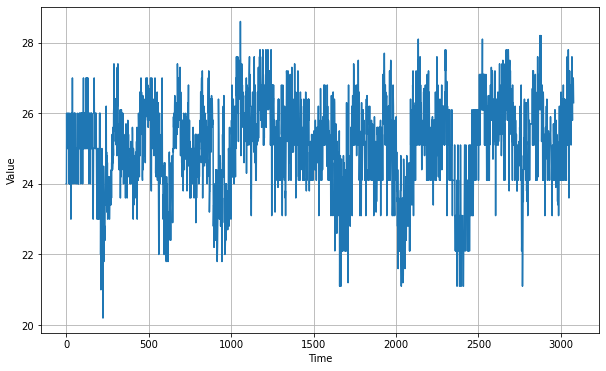

In [4]:
import csv
time_step = []
temps = []

with open(url) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2300
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2300,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
9/9 [==============================] - 5s 233ms/step - loss: 41.2681 - mae: 41.7650
Epoch 2/100
9/9 [==============================] - 2s 231ms/step - loss: 39.4400 - mae: 39.9365
Epoch 3/100
9/9 [==============================] - 2s 228ms/step - loss: 36.6144 - mae: 37.1106
Epoch 4/100
9/9 [==============================] - 2s 231ms/step - loss: 33.0704 - mae: 33.5673
Epoch 5/100
9/9 [==============================] - 2s 229ms/step - loss: 28.8300 - mae: 29.3275
Epoch 6/100
9/9 [==============================] - 2s 228ms/step - loss: 24.2784 - mae: 24.7758
Epoch 7/100
9/9 [==============================] - 2s 233ms/step - loss: 20.3436 - mae: 20.8419
Epoch 8/100
9/9 [==============================] - 2s 237ms/step - loss: 16.4794 - mae: 16.9781
Epoch 9/100
9/9 [==============================] - 2s 230ms/step - loss: 12.5208 - mae: 13.0192
Epoch 10/100
9/9 [==============================] - 2s 230ms/step - loss: 8.4374 - mae: 8.9343
Epoch 11/100
9/9 [=======================

(1e-08, 0.0001, 0.0, 60.0)

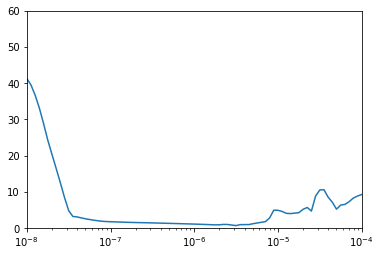

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
23/23 [==============================] - 5s 94ms/step - loss: 10.3467 - mae: 10.8357
Epoch 2/150
23/23 [==============================] - 2s 91ms/step - loss: 1.9844 - mae: 2.4466
Epoch 3/150
23/23 [==============================] - 2s 88ms/step - loss: 0.7706 - mae: 1.1805
Epoch 4/150
23/23 [==============================] - 2s 90ms/step - loss: 0.6557 - mae: 1.0559
Epoch 5/150
23/23 [==============================] - 2s 90ms/step - loss: 0.6333 - mae: 1.0316
Epoch 6/150
23/23 [==============================] - 2s 87ms/step - loss: 0.5551 - mae: 0.9430
Epoch 7/150
23/23 [==============================] - 2s 89ms/step - loss: 0.5436 - mae: 0.9292
Epoch 8/150
23/23 [==============================] - 2s 90ms/step - loss: 0.4864 - mae: 0.8649
Epoch 9/150
23/23 [==============================] - 2s 90ms/step - loss: 0.4521 - mae: 0.8248
Epoch 10/150
23/23 [==============================] - 2s 87ms/step - loss: 0.4833 - mae: 0.8626
Epoch 11/150
23/23 [===========================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

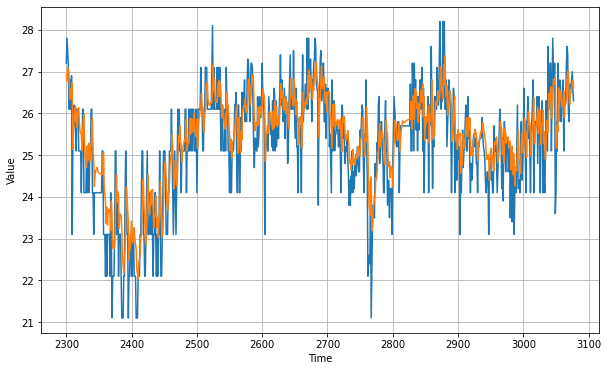

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.65461546

In [14]:
for n in range(28):
  print(rnn_forecast[n])

26.9136
26.772938
27.09859
27.066666
26.90838
26.46443
26.329678
26.58604
26.378185
26.737822
25.141928
25.601646
25.8719
26.080954
26.174948
25.96878
25.667213
25.980455
26.067131
26.133856
25.747496
25.592083
25.519627
25.492455
25.099054
25.391573
25.832996
25.975264
